# KORONAVIRUS

U jeku nove epidemije naše su misli cijeli dan, svaki dan, usmjerene na nove vijesti o stanju u državi i svijetu, broju zaraženih, oporavljenih i preminulih od nove bolesti. Budući da su svi ti podatci danas lako dostupni (a medicina je iznimno zanimljiva za proučavanje s matematičke točke gledišta), u ovom ćemo radu promatrati i analizirati te podatke. Pokušat ćemo predvidjeti mogući daljnji tijek epidemije i promatrati neke epidemiološke modele da bismo dobili jasnu predodžbu o (potencjialnoj) ozbiljnosti ove bolesti.

## Što je koronavirus?

Općenito, koronavirusi su virusi koji obično cirkuliraju među životinjama, no neki od njih mogu prijeći i na čovjeka, te se potom mogu i prenositi među ljudima.<br>
Prirodni domaćini tih virusa su šišmiši, ali i druge životinje mogu biti nositelji ovih virusa. Na primjer, koronavirus bliskoistočnog respiratornog sindroma (MERS-CoV) prenose deve dok SARS-CoV-1  cibetke, životinje iz reda zvijeri srodnih mačkama.<br><br>
Novi koronavirus otkriven u Kini 2019. godine, nazvan je SARS-CoV-2 (Severe Acute Respiratory Syndrome Coronavirus-2), te se ranije nije pojavljivao kod ljudi. Naziv bolesti uzrokovane ovim virusom jest COVID-19.Na temelju trenutno dostupnih podataka, zaključuje se da se virus relativno brzo šiti te procjenjuje da zaražena osoba u prosjeku zarazi dvije do tri osobe. naravno, na taj broj se može utjecata raznim preventivnim mjerama kojima smo ovih dana i mi sami svjedoci: izbjegavanje kontakata, ograničavanje kretanja, pranje ruku, itd.<br><br>
<i>Podatci su sa stranice: https://www.hzjz.hr/priopcenja-mediji/pitanja-i-odgovori-o-bolesti-uzrokovanoj-novim-koronavirusom/ .</i>

In [1]:
from IPython.display import Image

print("Model koronavirusa: \n(preuzet sa stranice https://www.turbosquid.com/3d-models/virus-coronavirus-2-3d-model-1504654 ):")
display(Image('korona_model.jpg', width=350))
print("Cibetka:\n(slika preuzeta sa stranice https://www.cerstvakava.cz/clanky/kopi-luwak-kava-na-niz-si-uz-pred-vami-pochutnaly-cibetky/ )")
display(Image('cibetka.jpg', width=350))

## Analiza podataka

Podatci su preuzeti sa stranice https://data.europa.eu/euodp/hr/data/dataset/covid-19-coronavirus-data i spremljeni u javni GitHub repozirotij. <br><br>
Podatci u tablici su sljedeći:<br><br>
```
    1. dateRep = promatrani datum u formatu 'dd/mm/gggg'
    2. day = broj dana u promatranom datumu
    3. month = broj mjeseca u promatranom datumu
    4. year = broj godine u promatranom datumu
    5. cases = broj novozaraženih na promatrani dan
    5. deaths = broj preminulih na promatrani dan
    6. countriesAndTerritories = naziv države
    7. geoId = iso kod države (alpha 2)
    8. countryterritoryCode = iso kod države (alpha 3)
    9. popData2018 = ukupan broj populacije iz 2018. za promatranu državu
```
<br>
Prije nego što krenemo prikazivati tablice i analizirati podatke, prvo želimo tablicu <i>srediti</i>. Vidimo odmah da u ovoj tablici ima redundancija (datumi) i nama nebitnih podataka (iso kodovi) pa ćemo prije svega uključiti potrebne biblioteke i riješiti se tih problema (pa usto i preimenovati preostajeće podatke u nešto <i>ljepše</i>).

In [2]:
import numpy as np
import pandas as pd
import requests

url = "https://raw.github.com/dominikmik195/mat_soft/master/preuzmi.csv"
data = pd.read_csv(url, encoding='utf-8')
data = data.rename(columns={'dateRep': 'Date', 'cases': 'Cases', 'deaths': 'Deaths', 'countriesAndTerritories': 'Country', 'popData2018': 'Population'})
data['Date'] = pd.to_datetime(dict(year=data['year'], month=data['month'], day=data['day']))
del data['day'], data['month'], data['year'], data['geoId'], data['countryterritoryCode']
data = data[::-1]

data.head()

,Date,Cases,Deaths,Country,Population,continentExp
12390,2020-03-21,1,0,Zimbabwe,14439018.0,Africa
12389,2020-03-22,1,0,Zimbabwe,14439018.0,Africa
12388,2020-03-23,0,0,Zimbabwe,14439018.0,Africa
12387,2020-03-24,0,1,Zimbabwe,14439018.0,Africa
12386,2020-03-25,0,0,Zimbabwe,14439018.0,Africa


Sad možemo pogledati grafički prikaz razvoja epidemije.<br>
Na sljedećem grafičkom prikazu vidimo kretanje broja zaraženih i preminulih u svijetu, u linearnoj i logaritamskoj skali.<br>
Ipak, koliko god su nam grafovi u linearnoj skali <i>ugodni oku</i>, graf u logaritamskoj skali nam daje još malo bolji uvid u različite brzine rasta:

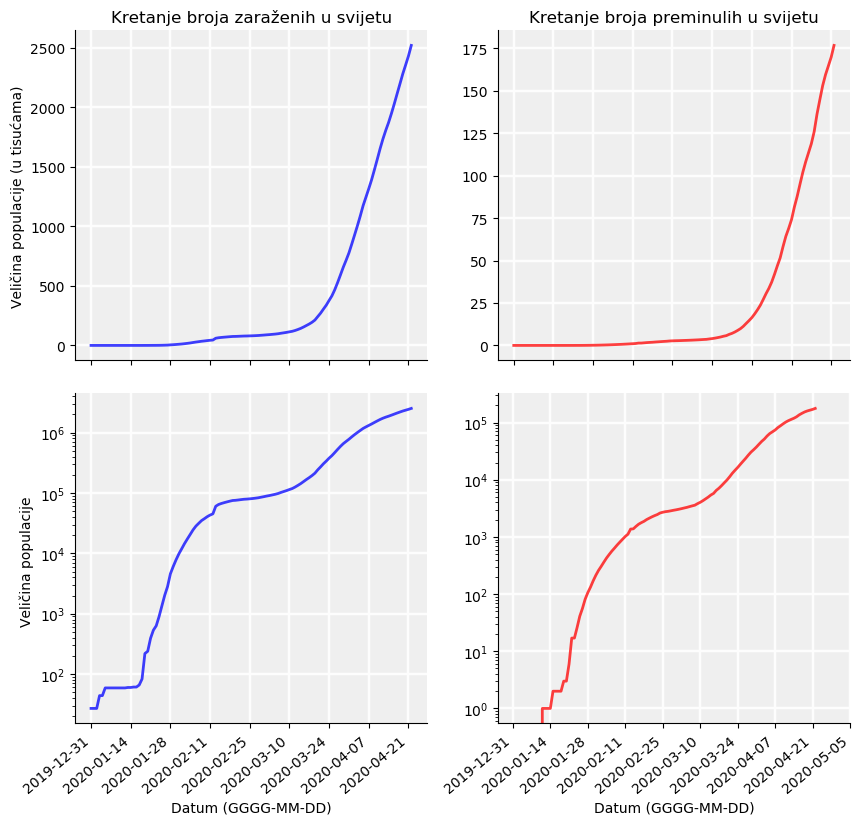

In [3]:
import datetime as dt
from functools import lru_cache
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 250
%matplotlib agg

def provjera(lista):
    for država in lista:
        if država == 'World': continue
        if država not in list(data['Country']): raise ValueError("Unijeli ste pogrešno ime!")
    return True

@lru_cache()
def izdvoji_državu(država):
    provjera([država])
    if država == 'World': return izdvoji_državu('China')
    return data[data['Country'] == država]

def ukupno_dnevno_stanje(argument):
    lista=[]
    suma = 0
    for broj in data.groupby(['Date']).sum()[argument]:
        suma += broj
        lista.append(suma)
    return lista

def lista_dnevno_stanje(država, argument):
    if država == 'World': return ukupno_dnevno_stanje(argument)
    lista = []
    i=-1
    for dnevno_stanje in np.array(izdvoji_državu(država)[argument]):
        if i==-1: lista.append(int(dnevno_stanje))
        else: lista.append(int(dnevno_stanje)+lista[i])
        i +=1
    return lista

pridjevi = {'Cases': 'zaraženi', 'Deaths':'preminuli', 0:'Cases', 1:'Deaths'}
skale = {0:'linear', 1:'log'}
boje = {0:'blue', 1:'red'}
jedinica = {0:1000, 1:1, 2:'(u tisućama)', 3: ''}
države = {država:'državi: \n'+ država.replace('_', ' ') for država in data['Country'].drop_duplicates()}
države['World'] = 'svijetu'

def prikaz_kontinuiranog_stanja(država):
    dates = np.array(izdvoji_državu(država)['Date'])
    k = 0
    for broj in izdvoji_državu(država)['Cases']: 
        if broj == 0: k += 1
        else: break
    if k > 2: k -= 2
    n = dates[k:].shape[0]//8
    base = dates[k]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 10)])
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, squeeze=True, figsize=(10, 9), gridspec_kw=dict(hspace=0.1))
    plt.xticks(rotation=40, ha='right')
    for i in range(0, 2):
        for j in range(0, 2):
            ax[i][j].grid(b=True, which='major', c='#fdfdfd', lw=1.75, ls='-')
            ax[i][j].set_facecolor('#efefef')
            ax[i][j].plot(dates[k:], np.array(lista_dnevno_stanje(država, pridjevi[j]))[k:]/jedinica[i], alpha=0.75, lw=2, color=boje[j])     
            ax[0][j].set_title('Kretanje broja ' + pridjevi[pridjevi[j]] + 'h u ' + države[država], fontsize='large')
            ax[i][0].set_ylabel('Veličina populacije ' + jedinica[i+2])
            ax[1][j].set_xlabel('Datum (GGGG-MM-DD)', fontsize='medium')
            ax[i][j].set_yscale(skale[i])
            plt.setp( ax[i][j].xaxis.get_majorticklabels(), rotation=40, ha='right')
            ax[i][j].set_xticks(dates2)
            ax[i][j].grid(b=True, which='major', c='#fdfdfd', lw=1.75, ls='-')
            for spine in ('top', 'right'):
                ax[i][j].spines[spine].set_visible(False)
    return fig

prikaz_kontinuiranog_stanja('World')

Ovako napisanu prethodnu funkciju možemo korsititi i da bismo prikazali podatke u svakoj pojedinoj državi.<br>
Pogledajmo stoga, na primjer, podatke u Italiji (ovdje iz donjih grafova, koji su u logaritamskoj skali, jasnije uočavamo kako se brzina rasta broja oboljelih i preminulih doista smanjuje, dok nam linearna skala to ne predočava toliko jasno):

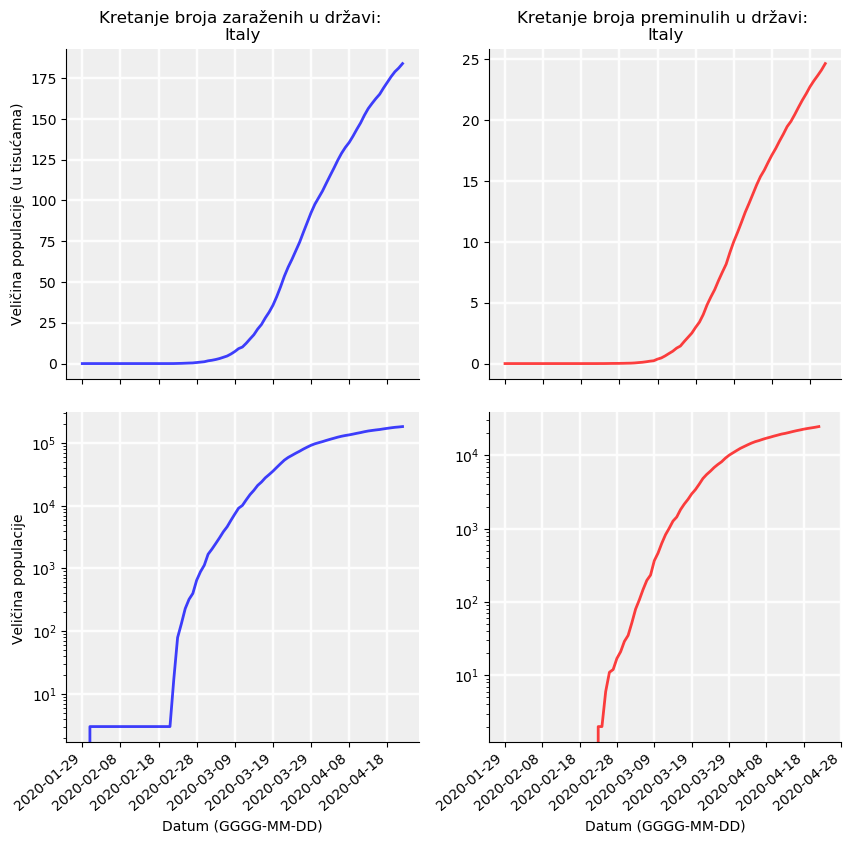

In [4]:
prikaz_kontinuiranog_stanja('Italy')

U medijima svakodnevno nailazimo na <i>usporedbe</i> stanja epidemije u različitim državama. Kao matematičari, mi ipak znamo da ovakve usporedbe imaju smisla jedino kada uspoređujemo udio broja zaraženih u ukupnoj populaciji. Idealno bi također bilo gledati koliki je udio preminulih u ukupnom broju zatvorenih slučajeva; međutim, podatci o broju ozdravljenih po svakoj državi zasebno nam nisu ovako dostupni kao i ostali podatci, pa ćemo također promatrati udio preminulih osoba u ukupnoj populaciji.

In [5]:
def pripremi_podatke(država, argument):
    dates = np.array(izdvoji_državu(država)['Date'])
    n = dates.shape[0]//10
    base = dates[0]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 12)])
    return [dates, dates2]
#još jedna pomoćna funkcija za bolju organizaciju podataka

def usporedba(lista):
    provjera(lista)
    brojevi = np.array([izdvoji_državu(država)[izdvoji_državu(država)['Cases']>=0].shape[0] for država in lista])
    broj = brojevi.max()
    k = 0
    for temp in brojevi:
        if broj == temp: break;
        k += 1
    fig, ax = plt.subplots(1, 2, sharex=True, squeeze=True, figsize=(10, 5), gridspec_kw=dict(hspace=0.1))
    for i in range(0, 2):
        for spine in ('top', 'right'):
            ax[i].spines[spine].set_visible(False)
        datumi = pripremi_podatke(lista[k], pridjevi[i])
        duljina = datumi[0].shape[0]
        ax[i].grid(b=True, which='major', c='#fdfdfd', lw=1.75, ls='-')
        ax[i].set_facecolor('#efefef')
        for država in lista:
            nova = lista_dnevno_stanje(država, pridjevi[i])[::-1]
            while len(nova) < duljina: nova.append(0)
            ax[i].plot(datumi[0], nova[::-1]/(np.array(izdvoji_državu(država)['Population'])[0]/100), alpha=0.75, lw=2, label = država.replace('_', ' '))
        ax[i].set_title('Usporedba kretanja broja ' + pridjevi[pridjevi[i]] + 'h', fontsize='large')
        ax[i].set_xlabel('Datum (GGGG-MM-DD)', fontsize='medium')
        plt.setp( ax[i].xaxis.get_majorticklabels(), rotation=40, ha='right')
        ax[i].set_xticks(datumi[1])
    ax[0].set_ylabel('Udio promatrane populacije (%)')
    ax[0].legend(loc = 'best')  
    return fig

Stoga prvo pogledajmo usporedbu između Hrvatske i nekih susjeda (Italiju ćemo ostaviti za kasnije). Da se razumijemo, poanta ovog dijela rada nije da epidemiju tretiramo kao 'natjecanje', već da iznesemo točne podatke i interpretiramo ih na ispravan (matematički) način. Stoga je jedina sigurnost koju u ovome grafu možemo vidjeti jest da između broja zaraženih i broja preminulih ne postoji neka jasna veza, jer iako Hrvatska ima najmanji broj preminulih, nema i najmanji broj oboljelih (<i>21. travnja</i>).<br><br>
<b>Važna napomena:</b><br>
Ja mogu interpretirati samo dio ovih podataka, jer se brojevi, to jest tijek epidemije, u državi, Europi i svijetu mijenja iz dana u dan. Podatci koje ja vidim danas (21. travnja) sigurno neće biti isti u trenutku kada Vi ovo čitate. Stoga će sve moje interpretacije podataka biti u kratkim crtama (ili s naznačenim datumom ako je prijeko potrebno) a detaljniju analizu ostavljam Vama.

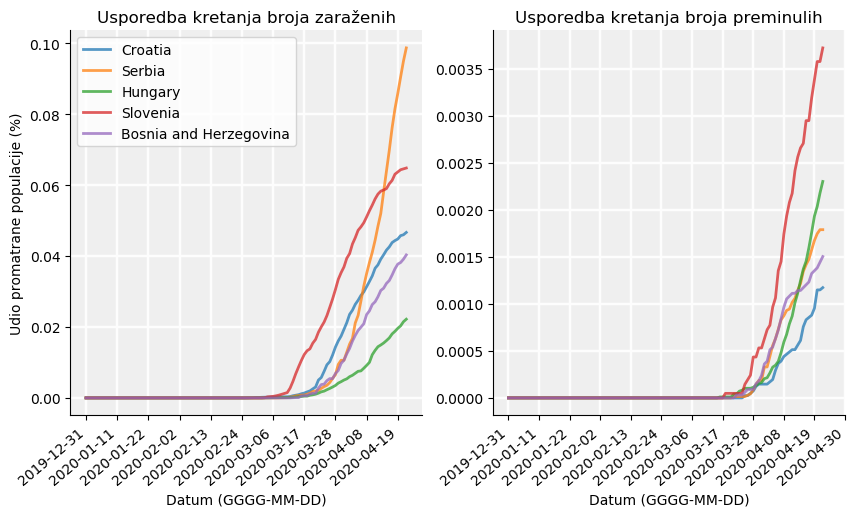

In [6]:
usporedba(['Croatia', 'Serbia', 'Hungary', 'Slovenia', 'Bosnia_and_Herzegovina'])

Još jedna usporedba koja bi nas mogla zaniati jest među državama koje imaju najveći broj zaraženih: Italija, Sjedinjene Američke Države, Španjolska, Francuska, Ujedinjeno Kraljevstvo, uključujući i državu iz koje potječe virus: Kina.<br><br>
Kad pogledamo podatke, odmah uočavamo da udio zaraženih u Kini ni u jednom trenutku (barem do 21. travnja 2020.) nije bio ni blizu onoliko velik koliki je u preostalim izdvojenim državama. Također, iako je u SAD-u najveći bro zaraženih, vidi se da Španjolska ima osjetno veći udio zaraženih. Ovaj graf nam je također još jedna potvrda da ne postoji nužno korelacija između broja zaraženih i preminulih (što zapravo i nije toliko čudno, jer valja imati na umu da način tretiranja bolesti ovisi o mnogo drugih faktora, jedan od kojih je i mogućnost financiranja tretmana).

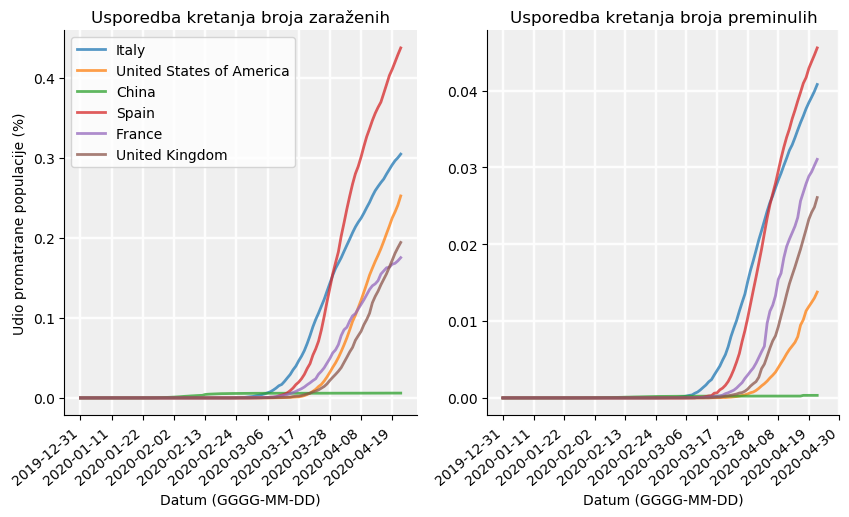

In [7]:
usporedba(['Italy', 'United_States_of_America', 'China', 'Spain', 'France', 'United_Kingdom'])

## Predviđanje daljnjeg razvoja epidemije

Naravno, nas ne zanima isključivo trenutno stanje, već nas zanima možemo li <i>predvidjeti</i> daljnji tijek ove epidemije?<br>
Odgovor: linearna regresija.<br><br>

U ovom slučaju, mi imamo dva vektora: $y$, koji predstavlja broj zaraženih, i $x$ koji predstavlja broj proteklih dana od početka epidemije. Naš model stoga izgleda ovako:<br>
$$y = \alpha x+\beta\ .$$ <br><br>
Mi sada metodom najmanjih kvadrata želimo procijeniti parametr $\alpha$ i $\beta$, uz važnu napomenu: ovdje je riječ o eksponencijalnom modelu, stoga ćemo mi zapravo primijeniti metodu najmanjih kvadrata na:<br><br>
$$\ln(y) = \ln(\alpha)\ln(x)+\ln(\beta)$$<br><br>
pa dobivene podatke <i>vratiti</i> natrag eksponenciranjem.
<br><br>
<i>Podatci su sa stranica: https://web.math.pmf.unizg.hr/nastava/mmub/exp.pdf , https://web.math.pmf.unizg.hr/nastava/mmub/logistic.pdf .</i>
<br><br>
Ovako možemo procijeniti potencijalni tijek epidemije, međutim ovdje imamo dva očita problema korištenja linearne regresije:
<lu>
    <li>U stvarnosti je rast rijetko gdje doista eksponencijalan, prije svega jer su nadležne vlasti reagirale relativno pravodobno i učile na dosadašnjim greškama ostalih nacija (jedan relativno dobar primjer je dakako i Hrvatska).</li>
    <li>Na mjestima gdje rast u početku i jest eksponencijalan, obično se on vrlo brzo stavi pod kontrolu pa nam funkcija dobivena ovom metodom više puno i ne koristi (npr. trenutno nam nema smisla na ovaj način procjenjivati podatke u Kini).</li>
</lu>

In [8]:
import statsmodels.api as sm

def pomoćni_ln(broj):
    if broj == 0: return 0
    else: return float(np.log(broj))

lnn = np.vectorize(pomoćni_ln, otypes=[np.float])

def vrati_procjenu(a, b):
    return lambda x: (np.e**a)*((np.e**b)**x)

def podatci_graf_regresija(država):
    provjera([država])
    dates = np.array(izdvoji_državu(država)['Date'])
    broj_dana = 0
    while np.array(izdvoji_državu(država)[izdvoji_državu(država)['Date']<=dates[broj_dana]]['Cases']).sum()==0:
        broj_dana += 1
    if broj_dana > 2: broj_dana -= 2
    brojač_dana = [i for i in range(0, dates.shape[0]-broj_dana)]
    brojač_dana2 = sm.add_constant(brojač_dana)
    zaraza = lnn(np.array(lista_dnevno_stanje(država, 'Cases'))[broj_dana:])
    model = sm.OLS(zaraza, brojač_dana2)
    rez = model.fit()
    print(rez.summary())
    funkcija = vrati_procjenu(rez.params[0], rez.params[1])
    n = dates[broj_dana:].shape[0]//10
    base = dates[broj_dana]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 12)])
    #također ne želimo da nam se prikaže apsolutno svaki datum jer je to nepregledno
    fig, ax = plt.subplots()
    ax.plot(dates[broj_dana:], lista_dnevno_stanje(država, 'Cases')[broj_dana:], alpha=0.75, lw=1.75, c='g', label='Pravi brojevi')
    ax.plot(dates[broj_dana:], np.vectorize(funkcija)(brojač_dana), alpha=0.75, c='c', lw=1.75, label='Procjena')
    plt.xticks(rotation=40, ha='right')
    for spine in ('top', 'right'):
        ax.spines[spine].set_visible(False)
    ax.set_xticks(dates2)
    ax.set_facecolor('#efefef')
    ax.set_title('Stvarni brojevi i dobiveni pomoću OLS u državi: ' + država.replace('_', ' '))
    ax.set_ylabel('Broj zaraženih')
    ax.set_xlabel('Datum (GGGG-MM-DD)')
    ax.legend(loc = 'best')
    ax.grid(b=True, which='major', c='#fdfdfd', lw=2, ls='-')
    return [fig, funkcija]

Ipak, jedan primjer kada nam je linearna regresija do neke mjere od pomoći jest Rusija, u kojoj je rast tek nedavno započeo te je još uvjiek (22. travnja 2020.) <i>otprilike</i> eksponencijalan. Stoga provedimo metodu najmanjih kvadrata:

In [9]:
podatci = podatci_graf_regresija('Russia')
funkcija = podatci[1]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     857.7
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           3.44e-45
Time:                        21:21:10   Log-Likelihood:                -126.77
No. Observations:                  84   AIC:                             257.5
Df Residuals:                      82   BIC:                             262.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8278      0.240     -7.630      0.0

Pogledajmo i grafički prikaz stvarnih podataka i dobivenih ovom metodom:

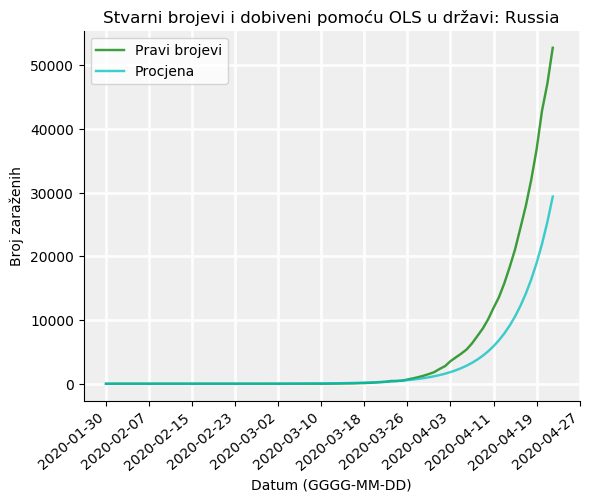

In [10]:
podatci[0]

Sada možemo i procijeniti broj zaraženih za tri dana:

In [11]:
round(funkcija((dt.datetime(2, 2, 3).today()-dt.datetime(2020, 2, 1)).days+3))

33995.0

Kao što sam naveo prije, u Hrvatskoj nam ova metoda ne pruža mnogo korisnih podataka jer rast nije eksponencijalan. Jasno vidimo da stoga ovaj rezultat nije egzaktan, pa niti daljnje procjene ne možemo prihvatiti s nekom pouzdanošću.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     621.0
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           2.72e-31
Time:                        21:21:10   Log-Likelihood:                -58.175
No. Observations:                  56   AIC:                             120.4
Df Residuals:                      54   BIC:                             124.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0662      0.184      5.806      0.0

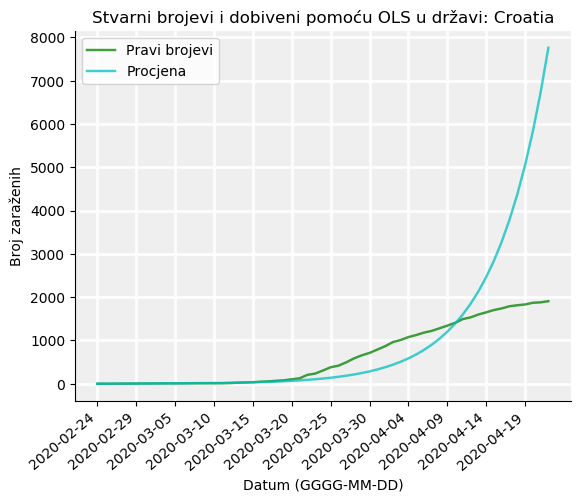

In [12]:
podatci_RH = podatci_graf_regresija('Croatia')
funkcija_RH = podatci_RH[1]
podatci_RH[0]

Za primjer, ovako dobivena funkcija nam kaže da bismo za tri dana trebali imati sljedeći broj zaraženih:

In [13]:
round(funkcija_RH((dt.datetime(2, 2, 3).today()-dt.datetime(2020, 2, 1)).days+3))

497645.0

Međutim, mislim da se možemo složiti da je vrlo malo vjerojatno da dosegnemo toliki broj zaraženih.

## Epidemiološki modeli

Ideja za nastavak rada bi bila proučiti relevantne epidemiološke modele za infektivne bolesti.<br>
Modeli se temelje na pretpostavci da imamo tri grupe ljudi:<br><br>
<lu>
    <li>oni koji su podložni bolesti (<i>susceptible</i> - S)</li>
    <li>širitelji zaraze (<i>infectious</i> - I)</li>
    <li>oporavljeni (<i>recovered</i> - R)</li>
</lu><br><br>
Ovisno o mogućnosti prijelaza imamo dva osnovna modela (koja bismo htjeli promatrati):<br><br>
<lu>
    <li> SIR - mogući su prijelazi iz podložnog bolesti u širitelj zaraze, te iz širitelja zaraze u oporavljenog, ali je glavna pretpostavka da se ljudi koji se oporave više ne mogu zaraziti</li>
    <li> SIRS - za razliku od SIR modela, ovdje se pretpostavlja da ljudi nakon što se oporave mogu opet biti podložni zarazi (nakon izvjesnog vremena)</li>
</lu><br>
SIR model je, stoga, zadan sljedećim sustavom diferencijalnih jednadžbi:<br><br>
$$S'=-\frac{\beta S I}{N}$$
$$I'=\frac{\beta S I}{N}-\gamma I$$
$$R'=\gamma I$$<br><br>
gdje je $\beta$ stopa zaraze, $\gamma = \frac{1}{D}$ stopa oporavka, s tim da je $D$ prosječno trajanje bolesti (u danima).

Slično tome, SIRS model je zadan ovako:<br><br>
$$S'=-\frac{\beta S I}{N}+\xi R$$
$$I'=\frac{\beta S I}{N}-\gamma I$$
$$R'=\gamma I - \xi R$$<br><br>
uz stopu gubitka imuniteta $\xi$.<br><br>
<i>Podatci su sa stranica: https://web.math.pmf.unizg.hr/nastava/mmub/7-epidemioloski.pdf , https://idmod.org/docs/general/model-sir.html .</i>

Na sljedećoj slici je vizualizacija oba modela (jer ukoliko je $\xi=0$, riječ je o SIR modelu, inače je riječ o SIRS modelu):

Prikaz SIR(S) modela
(preuzet sa stranice https://idmod.org/docs/general/model-sir.html )


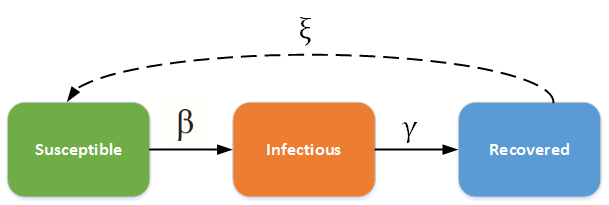

In [14]:
print("Prikaz SIR(S) modela\n(preuzet sa stranice https://idmod.org/docs/general/model-sir.html )")
display(Image('SIR.png', width=600))

Sad ćemo pogledati općeniti graf za SIR i SIRS model u ovisnosti o $\beta$, $\gamma$ i $\xi$ (i opet, za $\xi=0$ je riječ o SIS, a inače o SIRS modelu), za populaciju od 1000 ljudi. Te podatke dobijemo rješavanjem sustava običnih diferencijalnih jednadžbi koje su gore navedene. <br><br>
<i><b>Savjet</b>: ako ćete puno pomicati slidere, predlažem da povećate maksimalni dopušteni broj generiranih figura!</i>

In [15]:
from scipy.integrate import odeint
import ipywidgets as widgets

N = 1000
I0, R0 = 1, 0
S0 = N - I0 - R0
dani = np.linspace(0, 150, 150)

def deriv(y, t, N, beta, gama, ksi):
    S, I, R = y
    dSdt = -beta * S * I / N + ksi * R
    dIdt = beta * S * I / N - gama * I
    dRdt = gama * I - ksi * R
    return dSdt, dIdt, dRdt

def pomoc(beta, gama, ksi):
    y0 = S0, I0, R0
    rez = odeint(deriv, y0, dani, args=(N, beta, gama, ksi))
    S, I, R = rez.T

    fig, ax = plt.subplots()
    ax.plot(dani, S/1000, 'b', alpha=0.65, lw=2, label='Podložni zarazi')
    ax.plot(dani, I/1000, 'r', alpha=0.65, lw=2, label='Zaraženi')
    ax.plot(dani, R/1000, 'g', alpha=0.65, lw=2, label='Oporavljeni')
    ax.set_xlabel('Broj proteklih dana')
    ax.set_ylabel('Broj ljudi (u tisućama)')
    ax.set_ylim(0,1.2)
    ax.set_facecolor('#efefef')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='#fdfdfd', lw=1.75, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right'):
        ax.spines[spine].set_visible(False)
    return fig

k=widgets.interact(pomoc, beta=widgets.FloatSlider(value=0.2, min=0.1, max=1, step=0.05, description='$\\beta$'), 
                   gama=widgets.FloatSlider(value=0.1, min=0.05, max=0.2, step=0.025, description='$\\gamma$'), 
                   ksi=widgets.FloatSlider(value=0, min=0, max=0.2, step=0.005, description='$\\xi$'))

interactive(children=(FloatSlider(value=0.2, description='$\\beta$', max=1.0, min=0.1, step=0.05), FloatSlider…

Da bismo dobili stvarnu sliku ovih dvaju modela, prikazat ćemo stvarne podatke na području Hrvatske. Potrebne podatke sam kontinuirano prikupljao sa stranice https://www.koronavirus.hr/ i pohranio u datoteku korona_RH.csv.<br><br>
Budući da brzinu prijelaza iz <i>podložnih zarazi</i> u <i>zaraženi</i> i iz <i>zaraženi</i> u <i>oporavljeni</i> već imamo (to jest imamo stvarne podatke), ovdje ćemo prikazati podatke u ovisnosti o brzini prijelaza iz <i>oporavljeni</i> u <i>podložni zarazi</i>. Zapravo će nam podatci ovisiti o trajanju imuniteta u danima. Kada je taj parametar jednak -1, tada pretpostavljamo da svi koji su ozdravljeni imaju imunitet <i>zauvijek</i> (sukladno SIR modelu). Inače će naši podatci biti malo modificirani. Tako valja uočiti da kada je parametar jednak $0$, to znači da imunitet traje $0$ dana, to jest: osoba kada ozdravi, automatski prijelazi u skupinu ljudi koji su podložni zarazi - ovdje je riječ o SIS modelu!<br><br>
Napominjem samo da biram podatke prikazati "razdvojeno" jer je riječ o vrlo malim pomacima, to jest mali udio populacije je zaražen. Stoga, da prikazujem sve podatke na istom grafu, imali bismo dvije naizgled ravne crte iz kojih ništa ne bismo mogli zaključiti.

In [16]:
import copy

url = "https://raw.github.com/dominikmik195/mat_soft/master/korona_rh.csv"
data_RH = pd.read_csv(url)
data_RH['Date'] = pd.to_datetime(dict(year=data_RH['Year'], month=data_RH['Month'], day=data_RH['Day']))
del data_RH['Year'], data_RH['Month'], data_RH['Day']

N2=list(izdvoji_državu('Croatia')['Population'])[0]

def crtaj_RH_SIRS(trajanje_imuniteta):
    S=[]
    I=[]
    R=[]
    for podatak in data_RH['Cases']:
        S.append(N2-podatak)
    I = data_RH['Cases'] - data_RH['Recovered'] - data_RH['Deaths']
    R = copy.deepcopy(data_RH['Recovered'])
    if trajanje_imuniteta != -1:
        for i in range(int(trajanje_imuniteta), len(S)):
            S[i] += R[i-trajanje_imuniteta]
            R[i] -= R[i-trajanje_imuniteta]
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 5), gridspec_kw=dict(hspace=0.2))
    ax[0].plot(data_RH['Date'], S, c='b', label='Podložni zarazi')
    ax[1].plot(data_RH['Date'], I, c='r', label='Zaraženi')
    ax[1].plot(data_RH['Date'], R, c='g', label='Oporavljeni')
    plt.xticks(rotation=40, ha='right')
    for spine in ('top', 'right'):
        ax[0].spines[spine].set_visible(False)
        ax[1].spines[spine].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].tick_params(axis='x', color='w')
    for i in range(0, 2):
        ax[i].grid(b=True, which='major', c='#fdfdfd', lw=1.75, ls='-')
        ax[i].set_facecolor('#efefef')
        legend = ax[i].legend(loc='best')
        legend.get_frame().set_alpha(0.5)
    return fig

k=widgets.interact(crtaj_RH_SIRS, trajanje_imuniteta = widgets.FloatSlider(value=-1, min=-1, max=14, step=1, description='Imunitet'))

interactive(children=(FloatSlider(value=-1.0, description='Imunitet', max=14.0, min=-1.0, step=1.0), Output())…

Sad smo iz ovoga grafa vidjeli kako bi se kretao broj oporavljenih i podložnih zarazi u ovisnoti o trajanju imuniteta. Imajmo na umu da nam ta informacija samostalno možda ne znači puno, ali kad razmislimo kako bi se kasnije mogao kretati broj oboljelih, pa eventualno i preminulih, shvaćamo da razmjer epidemije može biti i još veći (pogotovo, naravno, ako imuniteta uopće nema - što znači da svi oni koji su ozdravili mogu ponovno oboljeti, i tako <i>u krug</i>). <br><br>
Ovdje nam se otvaraju i mnoge druge mogućnosti: što ako imamo cjepivo? Što ako uključimo period inkubacije (SIER model)? Upravo zato su nam epidemiološki modeli važni: jer nam pružaju uvid u mnoštvo različitih situacija ovisno o raznim parametrima koje smo dosad naveli. Koristeći te informacije možemo bolje regulirati preventivne mjere i (uz malo sreće) što prije proći kroz ovo razdoblje.

## Što smo postigli?

Vidjeli smo konkretne podatke o ovoj epidemiji u linearnoj i logaritamskoj skali, iz čega smo mogli preciznije vidjeti način na koji se bolest razvija. Zatim smo proveli dvije usporedbe pomoću kojih smo se podsjetili da apsolutni brojevi oboljelih nisu uvijek najbolji pokazatelj stanja u državi, već da nam udio može otkriti više. Usto smo uočili da broj zaraženih i broj preminulih ne mora nužno biti u svezi jedan s drugime.<br><br>
Potom smo pokušali predvidjeti daljnje kretanje podataka pomoću linearne regresije metodom najmanjih kvadrata i uvidjeli da ima slučajeva kad nam ta metoda može puno reći, ali da nam nakon određenog vremena i u određenim situacijama nije od velike koristi.<br><br>
Zatim smo analizirajući različite epidemiološke modele vidjeli moguće razmjere epidemije te na primjeru Hrvatske vidjeli potencijalno kretanje brojeva koje bi moglo biti 'stvarnije' od onoga koje zapravo imamo.<br><br>
U konačnici, bavili smo se stvarnim i <i>sirovim</i> podatcima i interpretirali ih samostalno, bez utjecaja medija ili bilo kojeg vanjskog čimbenika koji nerijetko iskrivi stvarno stanje.